In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import os
import scipy

In [2]:
# Test data file
url_datafile = "http://www.cv.nrao.edu/~sransom/GBT_Lband_PSR.fil"
fname = os.path.basename(url_datafile)

# Properties
headersize = 365
fch1 = 1447.5
foff = -1.0
nchan = 96
tsamp = 72e-6
nbit = 4

In [3]:
# Download file if it does not exist
if not os.path.isfile(fname):
    urllib.request.urlretrieve(url_datafile, fname)

In [4]:
# Read file as a byte array
byte_array = np.fromfile(fname, dtype='uint8')

In [5]:
# Extract 4 bit values from 8 bit byte array, skipping the header. Output is uint8
data = 8-(np.packbits(np.unpackbits(byte_array[headersize:]).reshape(-1, 4), axis=1)>>4).astype("float").reshape(-1, nchan).T

In [6]:
# Define frequencies and times
freqs = fch1+foff*np.arange(nchan)
t = np.arange(data.shape[1])*tsamp

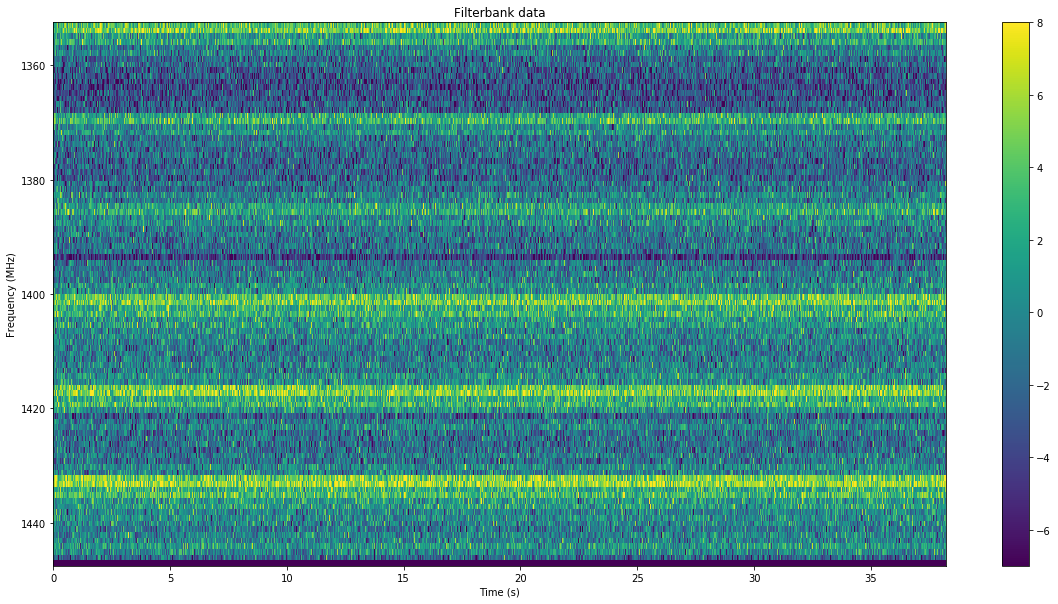

In [7]:
plt.figure(figsize=(20,10))
plt.title("Filterbank data")
plt.imshow(data, interpolation="None", aspect="auto", origin="lower", 
            extent=[np.min(t), np.max(t), np.max(freqs), np.min(freqs)])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
plt.colorbar()

In [8]:
def incoherent_dedispersion(tsamp, freqs, z, dm):
    # Compute output shape
    freqmin, freqmax = np.min(freqs), np.max(freqs)
    tdmax = (freqmin**(-2)-freqmax**(-2))*dm/2.41e-4
    zout = np.zeros_like(z)
    nfreq, nsamp = z.shape
    
    # Loop over channels
    for i, freq in enumerate(freqs):
        tdm = (freq**(-2)-freqmax**(-2))*dm/2.41e-4
        jmin, jmax = int(np.round(tdm/tsamp)), nsamp
        kmin, kmax = 0, nsamp-jmin
        zout[i, kmin:kmax] = z[i, jmin:jmax]
    
    return np.sum(zout, axis=0)

In [9]:
# Perform incoherent dedispersion
dms = np.arange(0, 120)
dmplane = np.zeros(len(dms)*len(t)).reshape(len(dms), len(t))
for i, dm in enumerate(dms):
    dmplane[i] = incoherent_dedispersion(tsamp, freqs, data-np.mean(data), dm)

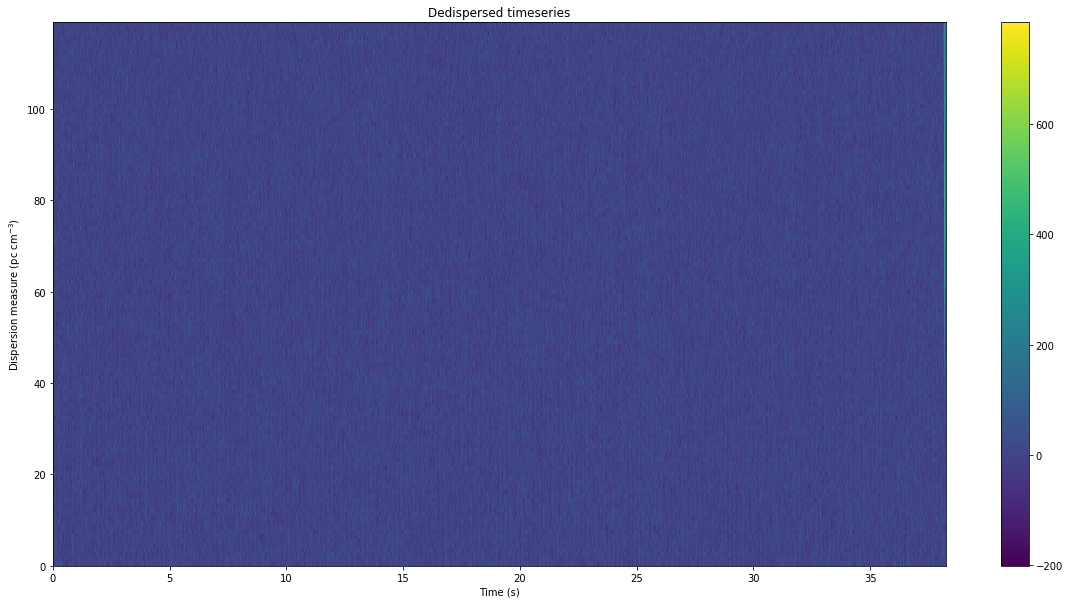

In [10]:
# Plot dedispersed timeseries
plt.figure(figsize=(20,10))
plt.title("Dedispersed timeseries")
plt.imshow(dmplane, interpolation="None", aspect="auto", origin="lower", 
            extent=[np.min(t), np.max(t), np.min(dms), np.max(dms)])
plt.xlabel("Time (s)")
plt.ylabel("Dispersion measure (pc cm$^{-3}$)")
plt.colorbar()

In [11]:
# FFT timeseries
fspins = np.fft.fftshift(np.fft.fftfreq(len(t), d=tsamp))
fplane = np.fft.fftshift(np.fft.fft(dmplane, axis=1), axes=1)
amps = np.absolute(fplane)
vmin, vmax = np.mean(amps)-2.0*np.std(amps), np.mean(amps)+10.0*np.std(amps)

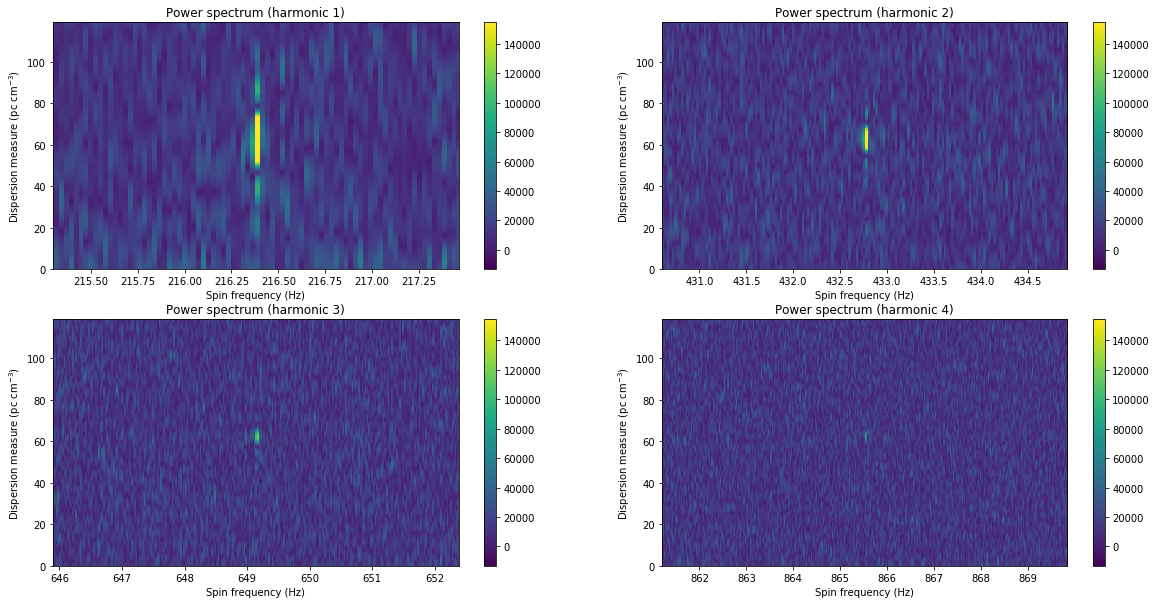

In [12]:
# Plot powerspectra
plt.figure(figsize=(20, 10))
fspin = 216.38
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(amps, interpolation="None", aspect="auto", origin="lower", 
                extent=[np.min(fspins), np.max(fspins), np.min(dms), np.max(dms)],
              vmin=vmin, vmax=vmax)
    plt.xlabel("Spin frequency (Hz)")
    plt.ylabel("Dispersion measure (pc cm$^{-3}$)")
    plt.xlim(0.995*(i+1)*fspin, 1.005*(i+1)*fspin)
    plt.title("Power spectrum (harmonic %d)"%(i+1))
    plt.colorbar()

DM = 62 pc/cc


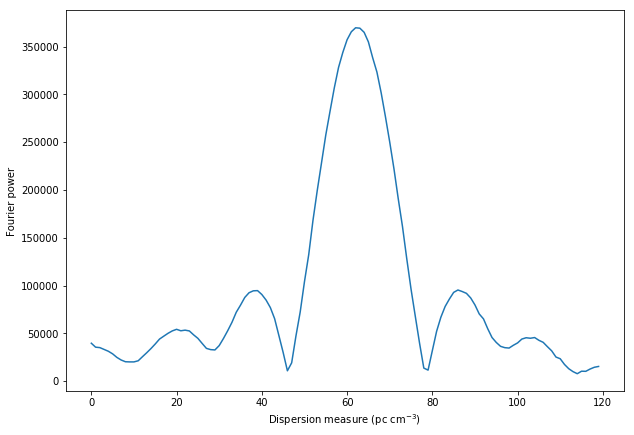

In [13]:
# Plot DM curve
idx = np.abs(fspins-fspin).argmin()
plt.figure(figsize=(10, 7))
plt.plot(dms, amps[:, idx])
plt.xlabel("Dispersion measure (pc cm$^{-3}$)")
plt.ylabel("Fourier power")
best_dm = dms[np.argmax(amps[:, idx])]
print("DM = %g pc/cc"%best_dm)

(0, 2000)

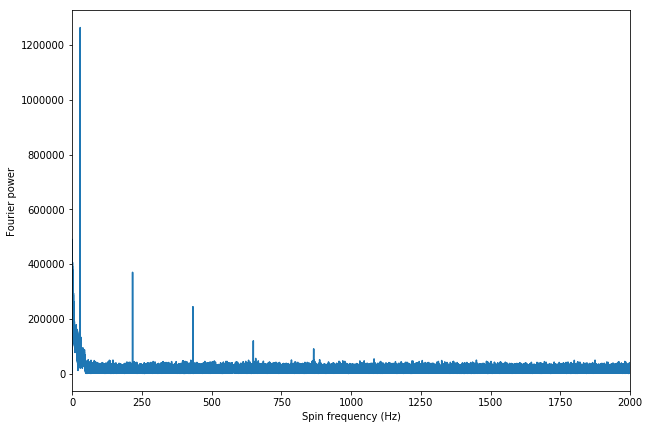

In [14]:
# Plot power spectrum
idx = np.abs(dms-best_dm).argmin()
plt.figure(figsize=(10, 7))
plt.plot(fspins, amps[idx, :])
plt.xlabel("Spin frequency (Hz)")
plt.ylabel("Fourier power")
plt.xlim(0, 2000)                   